In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from analysis import plot, utils # imoporting analysis module enables import from model folder
import analysis.pipelines.population_spikes as ps

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

PN_pop_names = ps.PN_pop_names
ITN_pop_names = ps.ITN_pop_names

In [3]:
# filter = (('short', 'long'), ('rand', 'div'))
# revert_junction = True
filter = ('rand', 'div')
revert_junction = False
exclude = 'baseline'

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(trials)

['short_rand', 'short_div', 'long_rand', 'long_div', 'ramp_a0_t0.3_rand', 'ramp_a0_t0.3_div', 'ramp_a0_t1.0_rand', 'ramp_a0_t1.0_div', 'ramp_a0_t1.0_down_rand', 'ramp_a0_t1.0_down_div', 'ramp_a0_t3.0_rand', 'ramp_a0_t3.0_div', 'join_a0_t0.3_rand', 'join_a0_t0.3_div', 'join_a0_t1.0_rand', 'join_a0_t1.0_div', 'join_a0_t1.0_quit_rand', 'join_a0_t1.0_quit_div', 'join_a0_t3.0_rand', 'join_a0_t3.0_div', 'fade_a01_t0.1_rand', 'fade_a01_t0.1_div', 'fade_a03_t0.1_div', 'fade_a01_t0.3_rand', 'fade_a01_t0.3_div', 'fade_a03_t0.3_div', 'fade_a01_t1.0_rand', 'fade_a01_t1.0_div', 'fade_a03_t1.0_div', 'fade_a01_t3.0_rand', 'fade_a01_t3.0_div', 'fade_a03_t3.0_div']


### Load ITN firing rate

In [4]:
lag_range = [-40, 80]  # ms. range time lags

lag_fr, T, ITN_fr_attrs = zip(*[ps.get_ITN_data(trial, lag_range) for trial in trials])

trial_slice = np.cumsum((0, ) + T)
trial_slice = dict(zip(trials, zip(trial_slice[:-1], trial_slice[1:])))
lag_fr = xr.concat(lag_fr, dim='time').stack(target=('population', 'lags'))

### Simulate actual STP weight

In [5]:
load_data = True

# pre_pop_names = PN_pop_names
# case_name = 'pop_spk_stp_w'
pre_pop_names = PN_pop_names + ITN_pop_names
case_name = 'pop_spk_stp_w_ITN'

pop_spk_stp_file = os.path.join(OUTPUT_PATH, case_name + '.nc')
load_data = load_data and os.path.isfile(pop_spk_stp_file)

pop_stp_info = ps.get_pop_stp_info(pre_pop_names, ITN_pop_names)
syn_types = pop_stp_info[0]

In [6]:
# Load input data
if load_data:
    stp_w = xr.load_dataset(pop_spk_stp_file).stp_w.stack(syn_type=('pre', 'post'))
else:
    # Setup stp objects
    trial_stp_objs = []
    trial_bin_spk_idx = []
    for trial, attrs, TT in zip(trials, ITN_fr_attrs, T):
        stp_objs, bin_spk_idx = ps.setup_pop_stp(trial, pop_stp_info, attrs, overwrite=overwrite)
        for bin_spk in bin_spk_idx.values():
            bin_spk[TT:] = []  # remove tail
        trial_stp_objs.append(stp_objs)
        trial_bin_spk_idx.append(bin_spk_idx)

    # Simulate stp
    ps.simulate_stp([obj for stp_objs in trial_stp_objs for obj in stp_objs.values()])

    # Get stp weigths
    stp_w = {syn: [] for syn in syn_types}
    for stp_objs, bin_spk_idx in zip(trial_stp_objs, trial_bin_spk_idx):
        for syn, stp_jump in stp_objs.items():
            P = stp_jump.P(concat=True)
            stp_w[syn].append(np.array([P[idx].sum() for idx in bin_spk_idx[syn[0]]]))
    stp_w = xr.DataArray(list(map(np.concatenate, stp_w.values())),
        coords=dict(syn_type=pd.MultiIndex.from_tuples(stp_w, names=['pre', 'post']),
        time=lag_fr.time)).transpose('time', 'syn_type')

    # Save input data
    stp_w.to_dataset(name='stp_w').unstack('syn_type').to_netcdf(pop_spk_stp_file)

### Predict ITN firing rate with spike data

In [7]:
# Drop synapse types since they have the same STP parameters
drop_syn = []
if 'FSI' in stp_w.pre:
    drop_syn.append(('FSI', 'FSI'))
if 'LTS' in stp_w.pre:
    drop_syn.append(('LTS', 'LTS'))
if drop_syn:
    stp_w = stp_w.drop_sel(syn_type=pd.MultiIndex.from_tuples(drop_syn))
    for syn in drop_syn:
        del syn_types[syn]

In [8]:
root_mean_squared_error = lambda *arg, **kwargs: mean_squared_error(*arg, **kwargs) ** 0.5
error_metrics = {'R2 score': r2_score, 'RMSE': root_mean_squared_error}

population = np.array(ps.ITN_pop_names)

def optimal_error(err_da, opt_idx):
    dim_opt = {dim: xr.DataArray(idx.values, dims='optimal') for dim, idx in opt_idx.items()}
    opt_err = err_da.isel(population=xr.DataArray(range(population.size),
        coords={'optimal': population}), **dim_opt).transpose('optimal', 'metric')
    return opt_err

In [9]:
fr_reg = LinearRegression()
fr_reg.fit(stp_w.values, lag_fr.values)
fr_pred = fr_reg.predict(stp_w.values)

pred_error = xr.DataArray([m(lag_fr.values, fr_pred, multioutput='raw_values') \
    for m in error_metrics.values()], name='prediction error',
    coords=dict(metric=list(error_metrics), target=lag_fr.target)).unstack('target')

optimal_idx = pred_error.sel(metric='RMSE').argmin(dim=['lags'])
optimal_param = xr.Dataset({d: pred_error.coords[d][optimal_idx[d]] for d in ['lags']})
print("Optimal parameters:")
display(optimal_param.to_pandas())
print("Minimum error:")
opt_error = optimal_error(pred_error, optimal_idx)
display(opt_error.to_pandas())

Optimal parameters:


,metric,lags
population,,
FSI,RMSE,0.0
LTS,RMSE,0.0


Minimum error:


metric,R2 score,RMSE
optimal,,
FSI,0.883256,1.498010
LTS,0.941563,1.887506


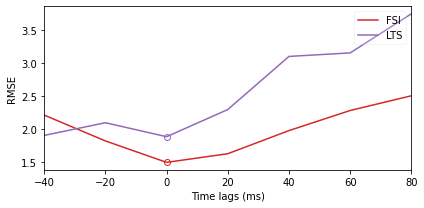

In [10]:
param_dims = {'lags': 'Time lags (ms)'}
error = pred_error.sel(metric='RMSE')

axs = plt.subplots(len(param_dims), 1, figsize=(6, 3 * len(param_dims)), squeeze=False)[1].ravel()
axs = axs.ravel()
for ax, (pdm, label) in zip(axs, param_dims.items()):
    for p in population:
        opt_p = optimal_param.sel(population=p)
        err = error.sel(population=p, **{d: opt_p[d] for d in param_dims if d != pdm})
        ax.plot(error[pdm], err, color=pop_color[p], label=p)
        ax.plot(opt_p[pdm], err.sel(**{pdm: opt_p[pdm]}),
                color=pop_color[p], marker='o', markerfacecolor='none')
    ax.set_xlim(error[pdm][[0, -1]])
    ax.set_xlabel(label)
    ax.set_ylabel(error.metric.item())
axs[0].legend(loc='upper right', framealpha=0.2)
plt.tight_layout()
plt.show()

In [11]:
linestyle = {'actual': '-', 'predict': '--'}
opt_pred = []
opt_coef = []
for p in population:
    opt_p = optimal_param.sel(population=p)
    trg = (p, opt_p.lags.item())
    opt_lag_fr = lag_fr.sel(target=trg).values
    trg_idx = lag_fr.target.to_index().get_loc(trg)
    opt_fr_pred = fr_pred[:, trg_idx]
    opt_pred.append([opt_lag_fr, opt_fr_pred])
    opt_coef.append(fr_reg.coef_[trg_idx].tolist() + [fr_reg.intercept_[trg_idx]])
opt_pred = xr.DataArray(opt_pred, name='optimal prediction', coords=dict(
    population=population, output=list(linestyle), time=lag_fr.time))
opt_coef = xr.DataArray(opt_coef, name='optimal coefficient', coords=dict(
    population=population, coef=list(syn_types.values()) + ['intercept']))
display(opt_coef)
# with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
#     print(opt_coef.values)

<xarray.DataArray 'optimal coefficient' (population: 2, coef: 7)>
array([[ 2.61908240e-01,  5.77360025e-02,  1.07725396e-01,
        -2.92388020e-02,  2.01464773e-01, -3.38173229e-03,
        -6.65004325e-01],
       [-2.58266410e+00,  5.09874675e-01,  1.88487106e-01,
         9.30899145e-02,  4.61648571e-02,  1.16541177e-02,
         5.28504659e+00]])
Coordinates:
  * population  (population) <U3 'FSI' 'LTS'
  * coef        (coef) <U9 'CP2FSI' 'CP2LTS' 'CS2FSI' ... 'LTS2FSI' 'intercept'

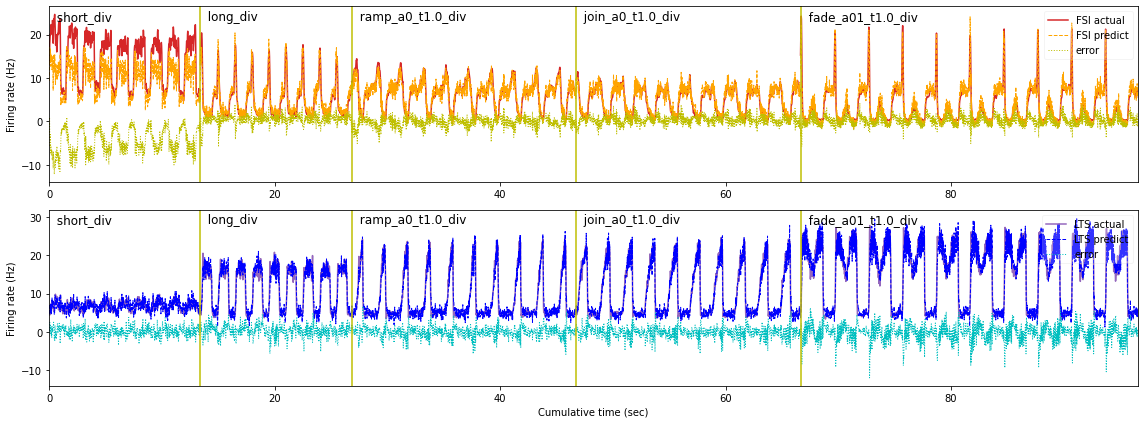

In [12]:
from matplotlib.transforms import blended_transform_factory

pred_clr = {'FSI': 'orange', 'LTS': 'blue'}
err_clr = {'FSI': 'y', 'LTS': 'c'}

# Show all trials
# show_trials = ps.get_trials([], trials=trials)

# Conditions for filtering trials
# trial_filt = (('short', 'long'), 'div')
trial_filt = (('short', 'div'), ('long', 'div'), ('t1.0', 'div'))
exclude = ('a03', 'down', 'quit')
# exclude = None
show_trials = ps.get_trials(trial_filt, trials=trials, revert_junction=False, exclude=exclude)

show_slice = {tr: trial_slice[tr] for tr in show_trials}

figsize = (16, 3)
axs = plt.subplots(population.size, 1, figsize=(figsize[0], figsize[1] * population.size), squeeze=False)[1].ravel()
T = 0
for i, (trial, idx) in enumerate(show_slice.items()):
    idx = slice(*idx)
    t = T + opt_pred.time[idx] / 1000
    T = t[-1]
    for p, ax in zip(population, axs):
        Ys = opt_pred.isel(time=idx).sel(population=p)
        for y in opt_pred.output.values:
            clr = pred_clr[p] if y == 'predict' else pop_color[p]
            linewidth = 1 if y == 'predict' else 1.5
            label = None if i else f'{p} {y}'
            ax.plot(t, Ys.sel(output=y), color=clr, linewidth=linewidth,
                    linestyle=linestyle[y], label=label)
        ax.plot(t, Ys.sel(output='predict') - Ys.sel(output='actual'), color=err_clr[p],
                linewidth=linewidth, linestyle=':', label=None if i else 'error')
        if i:
            ax.axvline(x=t[0], color='y')
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        ax.text(t[0], 0.98, '  ' + trial, transform=trans, fontsize='large',
                horizontalalignment='left', verticalalignment='top')
for ax in axs:
    ax.set_xlim([0, T])
    ax.set_ylabel('Firing rate (Hz)')
    ax.legend(loc='upper right', framealpha=0.2)
axs[-1].set_xlabel('Cumulative time (sec)')
plt.tight_layout()
plt.show()

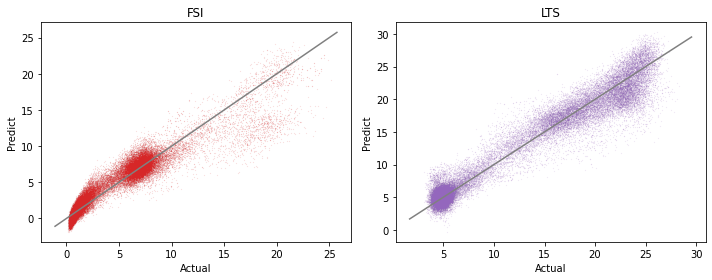

In [13]:
figsize = (5, 4)
axs = plt.subplots(1, population.size, figsize=(figsize[0] * population.size, figsize[1]), squeeze=False)[1].ravel()
for p, ax in zip(population, axs):
    Ys = opt_pred.sel(population=p)
    ax.plot(Ys.sel(output='actual'), Ys.sel(output='predict'), '.',
            color=pop_color[p], markersize=0.1)
    xl, yl = ax.get_xlim(), ax.get_ylim()
    xl = [max(xl[0], yl[0]), min(xl[1], yl[1])]
    ax.plot(xl, xl, 'gray')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predict')
    ax.set_title(p)
plt.tight_layout()
plt.show()